# INSTRUCTIONS (to read carefully and check!)

- [x] This programming exercise is to be completed in pairs (2 students). Not less, not more.

- [x] Fill in the name of each student in the cell below.  
**If you do not include both names, your submission will not be graded.**

- [ ] You must submit a single file per group on Moodle (this Jupyter notebook completed with your answers). Only one submission per group.  
**If you send more than one file, your submission will not be graded.**

- [ ] Your submission file must be named `APM52445_lastname1_lastname2.ipynb` (e.g., Aymeric Dieuleveut and Adrien Taylor will submit the file `APM52445_dieuleveut_taylor.ipynb`).  
**If you do not properly name your file, your submission will not be graded.**

- [ ] You Jupyter notebook must run on the free version of Google Collab using a T4 runtime environment. In this conditions, each cell should not take more than 4 minutes to run.  
**If your code does not run or any cell takes longer than 4 minutes to complete, your submission will not be graded.**

In [1]:
student1 = "Victor Soto"
student2 = "Clément Pottier"

# Robust learning on the CIFAR-10 dataset

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) provides 60000 32x32-pixel images, classified into 10 categories.

Your goals in this lab will be to:
1. Adapt and fine-tune a pretrained model to work on CIFAR-10
2. Evaluate the nominal and adversarial robustness of the fine-tuned model
3. Train a robust model on CIFAR-10
4. Evaluate the nominal and adversarial robustness of the robust model

It is recommended to use a GPU to run this notebook. This will drastically speed up computations.

In [2]:
import multiprocessing
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms, models

# If you have a GPU installed and configured correctly, this code will allow the use of gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    batch_size = 128
    pin_memory = True
else:
    print("No GPU found, running on CPU.")
    batch_size = 32
    pin_memory = False

Using GPU: Tesla T4


### Loading CIFAR-10 dataset from torchvision

In [3]:
# Mean, standard deviation, and labels
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)
CIFAR10_LABELS = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

# Define transforms for the training and testing datasets
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
    ]
)

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=multiprocessing.cpu_count(),
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=multiprocessing.cpu_count(),
    pin_memory=pin_memory,
)

100%|██████████| 170M/170M [00:03<00:00, 48.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Looking at a pretrained ResNet-18

`torchvision` provides a series of models and weights that have been (pre)trained on ImageNet1K, a subset of the ImageNet dataset. These pretrained models can be obtained by using the `weights` parameters as in:

In [4]:
model = models.resnet18(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s]


**Q. How many outputs does `model` have?**  
*(you must read out the answer directly from `model` rather writing an explicit number)*

In [5]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
model_outputs = model.fc.out_features
print(f"The model has {model_outputs} features")

The model has 1000 features


**Q. That's too many for CIFAR-10! Change the last layer to fit the CIFAR-10 dataset.**

In [7]:
# Modify the last fully connected layer to have 10 output features
model.fc = nn.Linear(model.fc.in_features, 10)

# Verify the change
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Q. Complete the function `nominal_accuracy` that takes a `model` and computes its accuracy on the test set.**

In [8]:
def nominal_accuracy(model):
    model.eval()
    test_acc = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            test_acc += (predicted == labels).sum().item()

    # Calculate accuracy as a percentage
    test_acc = test_acc / total

    return test_acc


model = model.to(device)
acc_pretrained = nominal_accuracy(model)
print(f"Test accuracy of pretrained model: {100*acc_pretrained:.2f}%")

Test accuracy of pretrained model: 10.35%


**Q. Why is the accuracy so low?**  
*(Tip: check the documentation of `torchvision.models.resnet18`)*

- Pre-trained Weights:
    - The pre-trained resnet18 model from torchvision is trained on the ImageNet dataset, which has 1,000 classes and is significantly different from the CIFAR-10 dataset, which has only 10 classes.
    - The features learned from ImageNet may not directly transfer well to CIFAR-10 without fine-tuning.
- Difference in Datasets:
    - ImageNet: Contains high-resolution images with a variety of objects and scenes.
    - CIFAR-10: Contains low-resolution (32x32) images of objects and animals in a more constrained setting.

## Fine tuning the pretrained ResNet-18

**Q. Train `model` on CIFAR-10 using SGD with step size $10^{-2}$ for 3 epochs.**  
*(this process of training for very few iterations a pretrained model is often called "fine tuning")*

In [9]:
epochs = 3
model.train()


# We define an optimizer that will update the model's parameters
# to minimize the error:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # given learning rate

# We define take the Cross-Entropy Loss as our function:
criterion = nn.CrossEntropyLoss()

# We iterate trough the training data for 3 epochs
# (load a batch of images -> predicitons -> loss -> gradients -> update param):
for epoch in range(epochs):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


In [10]:
acc_finetuned = nominal_accuracy(model)
print(f"Test accuracy of fine-tuned model: {100*acc_finetuned:.2f}%")

Test accuracy of fine-tuned model: 76.45%


## Evaluating the robustness of the fine-tuned ResNet-18

While our fine-tuned `model` now has good accuracy on CIFAR-10, it turns out to be extremely sensitive to input perturbations. In fact, our `model` can be fooled by small perturbations of the CIFAR-10 images that are *invisible to the naked eye*. That's exactly what we're gonna show next.

To do that, the idea is to essentially turn everything we've done so far on its head. Up until now, we have fixed the inputs (the data points $x_n$) and tried to **find the parameters $\theta$ that minimize the loss**, i.e.,
$$
\text{(PI):} \quad \min_{\theta}\ \frac{1}{N} \sum_{n=1}^N \text{Loss}(f_\theta(x_n),y_n)
    \text{,}
$$
where $f_\theta$ is our model. We did that by using, for instance, stochastic gradient descent as in
$$
\theta_{t+1} = \theta_{t} - \eta \nabla_{\theta} \text{Loss}(f_\theta(x_n),y_n)
    \text{,} \quad n \sim \text{Uniform}([1,N])
    \text{.}
$$

Instead, we are now going to fix the parameters $\theta$ and some input $(x^\prime,y^\prime)$ and **find an input $x$ close to $x^\prime$ that maximizes the loss**, i.e.,
$$
\text{(PII):} \quad \max_{\Vert x - x^\prime \Vert_{\infty} \leq \epsilon}\ \text{Loss}(f_\theta(x),y^\prime)
    \text{.}
$$
By maximizing the loss with respect to the correct class $y^\prime$, we are finding an image $x$ that our model does not classify as $y^\prime$. But if that image is so close to $x^\prime$ that we (humans) cannot tell them apart, then clearly our model has made a mistake. To achieve that, (PII) only optimizes over inputs $x$ such that $\Vert x - x^\prime \Vert_{\infty} \leq \epsilon$. Recall that $\Vert z \Vert_\infty = \max_i \vert z_i \vert$. In words, this means that the value of each pixel of $x$ cannot be more than $\epsilon$ away from the original image $x^\prime$. So $\epsilon$ is the "strength of our attack."

Typically, we only care about very small $\epsilon$ (say 3% of the maximum pixel value). Why? Because otherwise (PII) would just replace every image in CIFAR-10 by a picture of one of your instructors, which would completely confuse our model since none of us are part of CIFAR-10! (what would our labels even be?! Don't answer that...). No, we want $x$ and $x^\prime$ to look almost the same to us (humans) so that our model is actually making a mistake by not assigning the class $y^\prime$ to $x$.

### Algorithm development

You will now develop an algorithm to solve (PII). To do so, observe 4 important differences between (PI) and (PII):

1. (PII) optimizes over $x$ and not $\theta$, i.e., we need to use the gradient with respect to the input $\nabla_x \text{Loss}(f_\theta(x),y^\prime)$ and **not** the gradient with respect to the parameters $\nabla_{\theta} \text{Loss}(f_\theta(x),y^\prime)$;

**Q. Complete the function `grad_input` which computes the gradient of the loss with respect to the input (and not the parameters!).**  
*Tip: PyTorch will only compute gradients for any `torch.tensor` that has `requires_grad=True`.*  
*Tip: Check the shape of your output: it has to match `inputs.shape`.*

In [12]:
def grad_input(model, inputs, targets, criterion):

    # Ensure inputs require gradients
    inputs.requires_grad = True

    # Forward pass
    outputs = model(inputs)

    # Compute the loss
    loss = criterion(outputs, targets)

    # Compute the gradient of the loss with respect to the inputs
    grad_wrt_inputs = torch.autograd.grad(loss, inputs, retain_graph=True, create_graph=True)[0]

    # Check that the shape of the output is the same as the input
    assert grad_wrt_inputs.shape == inputs.shape, f"Expected shape {inputs.shape}, but got {grad_wrt_inputs.shape}"

    return grad_wrt_inputs


max_grad = 0.0
for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    grad = grad_input(model, inputs, targets, torch.nn.CrossEntropyLoss())
    max_grad = max(max_grad, grad.abs().max().item())

print(f"The maximum absolute value of the gradient is {max_grad:.3f}.")

The maximum absolute value of the gradient is 0.014.


2. (PII) typically uses a pretrained network, so $\nabla_x \text{Loss}(f_\theta(x),y^\prime)$ is very small (see above). To overcome that, we use the *sign of the gradient* in the update and **not** than the gradient itself;
3. (PII) *maximizes* rather than *minimizes* the loss, i.e., we need to do gradient *ascent* and **not** gradient *descent*;
4. (PII) only considers inputs $x$ close to the reference $x^\prime$. In fact, the value of the each pixel of $x$ cannot be more than $\epsilon$ away from the value of the same pixel in $x^\prime$. To ensure that our updates stay within $\epsilon$ of $x^\prime$, we use a *projection* after each update. In this case, the projection reduces to clipping as in
    $$
    \text{Projection}(x) = x^\prime + \big[ x - x^\prime \big]_{-\epsilon}^{\epsilon}
    \text{,}
    $$
    where $\big[ z \big]_{-\epsilon}^{\epsilon}$ "clips" (or "clamps") $z$ to $[-\epsilon,\epsilon]$.
    In math, we write that as $\big[ z \big]_{-\epsilon}^{\epsilon} = \min(\max(z,-\epsilon),\epsilon)$.

**Q. Use these four observations to modify the GD algorithm to solve (PII).**

Je capte pas s'ils attendent une explication ou si faut coder quelque chose


#
#
# YOUR CODE OR ANSWER HERE
#
#

**Q. Complete the function `grad_attack` that uses this algorithm to find modifications of `input` ($x^\prime$) that maximize the loss (`criterion`) of `model` ($f_\theta$).**  
1. initialize $x_0$ randomly in $\Vert x - x^\prime \Vert_{\infty} \leq \epsilon$
1. compute the gradient of the loss (cross-entropy) with respect to the input at $x_k$
1. update $x_k$ using the signed gradient ascent with step size `eta`
1. project the result to get $x_{k+1}$
1. repeat for `iterations`

In [46]:
def grad_attack(model, inputs, targets, epsilon, eta, iterations):
    model.eval()

    inputs = inputs.clone().detach()  # Ensure inputs do not have history
    mod_inputs = inputs + torch.empty_like(inputs).uniform_(-epsilon, epsilon)
    mod_inputs.requires_grad = True  # Enable gradient tracking

    for _ in range(iterations):
        # Forward pass
        outputs = model(mod_inputs)
        loss = torch.nn.CrossEntropyLoss()(outputs, targets)

        # Compute the gradient of the loss with respect to the input
        grad = torch.autograd.grad(loss, mod_inputs, retain_graph=False, create_graph=False)[0]

        # Update mod_inputs using the signed gradient ascent
        mod_inputs = mod_inputs + eta * torch.sign(grad)

        # Project mod_inputs back into the epsilon-ball of inputs
        mod_inputs = inputs + torch.clamp(mod_inputs - inputs, -epsilon, epsilon)

        # Ensure mod_inputs stays in the computation graph
        mod_inputs = mod_inputs.detach().clone().requires_grad_(True)

    return mod_inputs

**Q. Complete the function `robustness` that takes a `model` and computes its accuracy after modifying the input with `grad_attack`.**  
*Since we modify normalized inputs, we need to consider values of `epsilon`, the magnitude of our modifications, that are proportional to the range of the normalized CIFAR-10 images.*  
*Set `epsilon` to 3% of that range  ($0.03 \times 2.5$), `eta` = `epsilon`/20, and `iterations`=50).*

In [47]:
def robustness(model):
    model.eval()
    robust_acc = 0

    total = 0

    epsilon = 0.03 * 2.5  # 3% of the normalized range
    eta = epsilon / 20
    iterations = 50

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Apply the adversarial attack (DO NOT use torch.no_grad() here)
        mod_inputs = grad_attack(model, inputs, targets, epsilon, eta, iterations)

        with torch.no_grad():  # Now safe to disable gradients for evaluation
            # Get the model's predictions on the modified inputs
            outputs = model(mod_inputs)
            _, predicted = torch.max(outputs, 1)

            # Calculate the accuracy
            robust_acc += (predicted == targets).sum().item()
            total += targets.size(0)

    # Compute the overall robust accuracy
    robust_acc /= total

    return robust_acc

robust_acc_finetuned = robustness(model)
print(f"Robustness of pretrained model: {100*robust_acc_finetuned:.3f}%")

Robustness of pretrained model: 0.910%


**Q. What happened to the accuracy of our ResNet-18? How come it went from over 70% to worst than a random classifier?**

The significant drop in accuracy of your ResNet-18 model, from over 70% to worse than a random classifier, after applying adversarial attacks, can be attributed to the model's vulnerability to adversarial examples.

- We have created adversarial examples from inputs that have been slightly modified to cause the model to make mistakes. The modifications are typically imperceptible to humans but can lead to significant errors in the model's predictions.
- However, Deep learning models can be highly sensitive to small perturbations in the input data, explaining this drastic drop in the result.
- Moreover, we maximized the loss with The grad_attack function using gradient ascent to find small perturbations that maximize the loss.

To conclude, we can explain this result answering that everything was made to find the worst-case scenario for the model, leading to incorrect predictions and a very slow accuracy

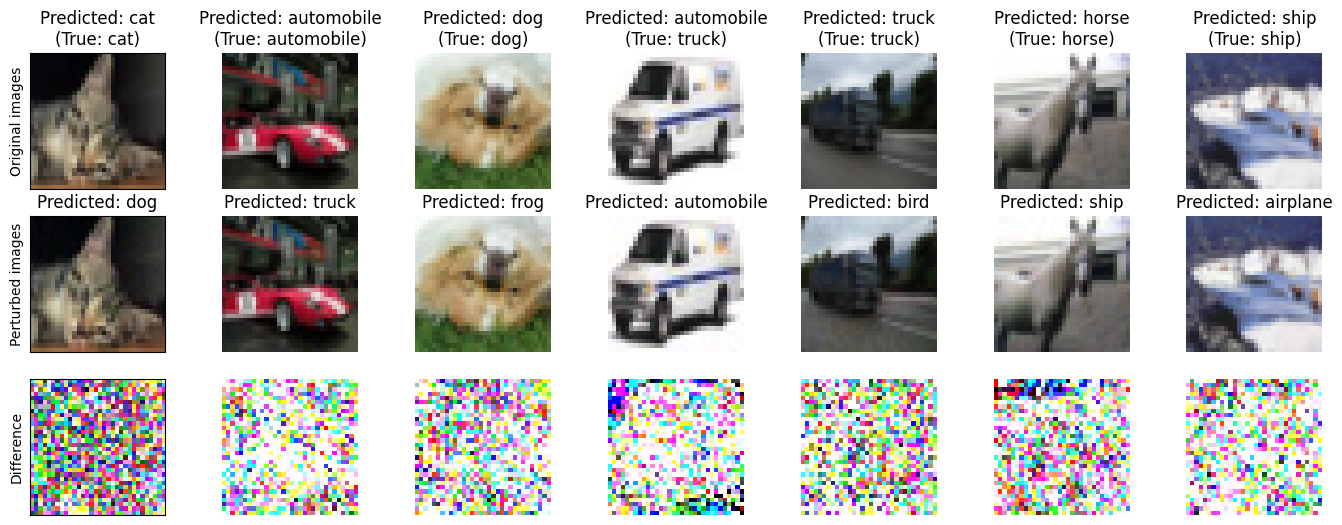

In [51]:
def unnormalize(x):
    std = torch.tensor([[0.2023, 0.1994, 0.2010]]).reshape((3, 1, 1))
    mean = torch.tensor([[0.4914, 0.4822, 0.4465]]).reshape(3, 1, 1)
    return torch.clamp(x * std + mean, 0, 1)

fig, axes = plt.subplots(3, 7, figsize=(17, 6))

for n, idx in enumerate(np.random.randint(0, len(test_dataset), 7)):
    input, target = test_dataset[idx]
    input, target = input.to(device), torch.tensor([target], device=device)

    mod_input = grad_attack(
        model, input.unsqueeze(0), target, epsilon=0.03 * 2.5, eta=0.03 * 2.5 / 20, iterations=50
    )

    _, pred = model(input.unsqueeze(0)).max(1)
    _, mod_pred = model(mod_input).max(1)

    # Detach tensors before visualization
    input_img = unnormalize(input.to("cpu")).movedim(0, 2).detach().numpy()
    axes[0, n].imshow(input_img)
    _ = axes[0, n].set_title(f"Predicted: {CIFAR10_LABELS[pred.item()]}\n(True: {CIFAR10_LABELS[target.item()]})")

    mod_input_img = unnormalize(mod_input.to("cpu").squeeze()).movedim(0, 2).detach().numpy()
    axes[1, n].imshow(mod_input_img)
    _ = axes[1, n].set_title(f"Predicted: {CIFAR10_LABELS[mod_pred.item()]}")

    # Compute the absolute difference using np.abs
    difference = np.abs(input_img - mod_input_img)
    axes[2, n].imshow(difference / difference.max())

for ax in axes.flatten():
    ax.axis("off")

axes[0, 0].set_axis_on()
axes[0, 0].xaxis.set_visible(False)
axes[0, 0].tick_params(left=False, labelleft=False)
_ = axes[0, 0].set_ylabel("Original images")

axes[1, 0].set_axis_on()
axes[1, 0].xaxis.set_visible(False)
axes[1, 0].tick_params(left=False, labelleft=False)
_ = axes[1, 0].set_ylabel("Perturbed images")

axes[2, 0].set_axis_on()
axes[2, 0].xaxis.set_visible(False)
axes[2, 0].tick_params(left=False, labelleft=False)
_ = axes[2, 0].set_ylabel("Difference")

plt.show()

**Q. Do the images look different? Do their differences look like anything? How come our model is now consistently wrong on images it used to get right?**

- The images really don't look different. This result is not surprising since we implemented our input modification to be very small so that not visible to human eyes.
- Their difference is very irregular, it appears to be noise. But this noise was optimize in order to maximize the loss of the prediction. It really underlines the sensibility of Deep Learning algorithm to small perturbations in the input data.

**Q. Fine tune your (already fine tuned) CIFAR-10 model by training on modified inputs instead of clean ones. In other words, train on images after running them through `grad_attack`.**  
*Train your model using SGD with step size $10^{-3}$ for 3 epochs.*  
*To speed up your training, use a much weaker attack by keeping `epsilon` as before but setting `eta` = `epsilon`/3 and `iterations` = 5.*

In [ ]:
epochs = 3


#
#
# YOUR CODE OR ANSWER HERE
#
#


In [ ]:
acc_adv = nominal_accuracy(model)
print(
    f"Test accuracy of adversarially trained model: {100*acc_adv:.2f}%"
    f" (before adversarial training: {100*acc_finetuned:.2f}%)"
)

robust_acc_adv = robustness(model)
print(
    f"Robustness of adversarially trained model: {100*robust_acc_adv:.2f}%"
    f" (before adversarial training: {100*robust_acc_finetuned:.2f}%)"
)

**Q. Compare the nominal accuracy (accuracy on clean samples) and robustness (accuracy on modified samples) of your model before and after adversarial training. Do you notice any patterns?**

**BONUS: How would you go about dealing with it?**


#
#
# YOUR CODE OR ANSWER HERE
#
#
